# 3202 Final Project- OpenAI Gym Taxi Game

by Adhir Uchil

### Overview

This project is about build a reinforcement learning agent to solve the Taxi Game. The Taxi Game is a simple text-based game where the objective is to control a taxi agent and pick up the customer from one location and drop them at the destination. 

I will build two different learning agents to solve this game- a random agent that picks each action arbitrarily and a The model will use Q-Learning technique to train the agent to maximize its score in the game. 

### Environment: The Taxi Game

The taxi game environment is a two dimensional grid world with four main locations titled "Red", "Green", "Yellow", "Blue". The aim of the game is to pick the passenger from one of these locations and drop them off to another, thus ending the episode. Each step has a reward of -1, so the taxi is incentivized to find the optimal route, first to the passenger and then the destination.

There are 6 actions that the taxi can perform:
- 0: Move south
- 1: Move north
- 2: Move east
- 3: Move west
- 4: Pick up passenger
- 5: Drop off passenger

These actions are depicted by the numbers 0 to 5 in the model. 

Apart from the -1 existence reward, there are two other rewards:
- a penalty of -10 if the taxi executes the pick up or drop off commands illegally
- a reward of +20 for successfuly transporting the passenger

The grid world has dimensions of 5 x 5, so there are 25 possible taxi positions. There are also 5 possible positions the passenger can occupy ("R","G","Y","B" or inside the taxi) and 4 possible destinations ("R","G","Y","B"). In all, this means there are 5 x 5 x 5 x 4 = 500 possible states.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from IPython import display

In [4]:
env = gym.make("Taxi-v3")

In [5]:
# There are 6 avaialable actions
num_actions = env.action_space.n
num_actions

6

In [6]:
# There are 500 states
num_states = env.observation_space.n
num_states

500

In [7]:
# Function to visualize the game
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

### Model

I will consider two models here- first a random model that just performs a random action at each step without any learning. Then I will build a Q-Learning model that performs reinforcement learning by maintaining a Q-table that contains the Q-Value of every state-action pair. I will train this model using the Bellman equation to update the Q-values of the table. Eventually, I will use this Q-table to derive the policy with which I will perform a few test runs of the game and confirm that the taxi is picking up the passenger as intended.

The random implementation is below. OpenAI has an inbuilt limit of 199 steps before it stops the training, so we can see here that the taxi does not even pick up the passenger before the limit is reached in most cases, as well as tries to drop or pickup illegally, both of which leads to a highly negative average score.

In [59]:
def random_agent(num_episodes):
    rewards = []
    for i in range(num_episodes):
        env.reset()
        done = False
        total_reward = 0
        while not done:
            action = env.action_space.sample()
            state, reward, done, _ = env.step(action)

            total_reward += reward
        #     show_state(env, step)
        rewards.append(total_reward)
    return rewards

In [60]:
num_episodes = 200
rewards_rand = random_agent(num_episodes)
print("Average score:", np.mean(rewards_rand))

Average score: -773.22


Now, we will train the Q-value agent. We will use a learning rate `alpha` of 0.1. We will also have a parameter `epsilon` with value 0.1 to denote the exploration-exploitation tradeoff: with probability 0.1 we will explore a new action (i.e. choose an action randomly) and with probability 0.9 we will choose the best action recommended by our policy (store in the Q-table) so far. Lastly, the decay rate `gamma` will be set to 0.6.

In [72]:
# Initializing the Q-table
q_table = np.zeros([num_states, num_actions])
q_table

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [73]:
def train_qtable(q_table, num_episodes, alpha, gamma, epsilon):
    for episode in range(total_episodes):
        state = env.reset()
        step = 0
        done = False

        while not done:
            tradeoff = np.random.random()
            # With probability epsilon, choose a random action
            if tradeoff < epsilon:
                action = env.action_space.sample()
            # With probability 1 - epsilon, choose the optimal action
            else:
                action = np.argmax(q_table[state, :])

            new_state, reward, done, _ = env.step(action)

            # Update Q-table 
            old_q = q_table[state, action]
            next_q_max = np.max(q_table[new_state])

            new_value = (1 - alpha) * old_q + alpha * (reward + gamma * next_q_max)
            q_table[state, action] = new_value

            state = new_state

            if done:
                break
            

In [74]:
num_episodes = 1000
alpha = 0.1
gamma = 0.6
epsilon = 0.1
train_qtable(q_table, num_episodes, alpha, gamma, epsilon)

With the Q-table thus trained, we can now test it over a number of episodes to see how the score differs compared to the random model. 

In [75]:
def test_qtable(q_table, num_episodes, show_images=False):
    rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        step = 0
        done = False
        total_reward = 0

        while not done:
            if show_images:
                show_state(env, step)

            action = np.argmax(q_table[state, :])

            new_state, reward, done, info = env.step(action)

            total_reward += reward

            if done:
                rewards.append(total_reward)
                break

            state = new_state
    return rewards

In [76]:
num_episodes = 200
rewards_q = test_qtable(q_table, num_episodes)
print("Average score:", np.mean(rewards_q))

Average score: 8.005


This is much better! We get a positive score, which means that the taxi succeeds in dropping of the passenger most often.

Here is a **visual demonstration** of the agent solving the taxi game:

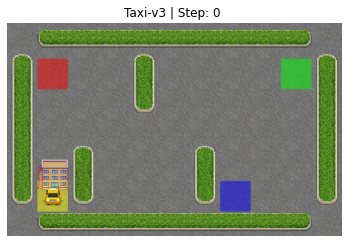

[8, 8, 5, 7, 9, 7, 8, 9, 7, 10]

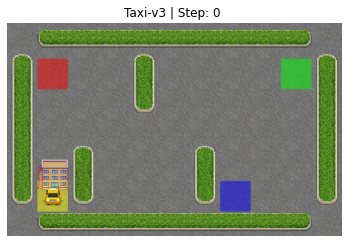

In [65]:
test_qtable(q_table, 10, True)

### Results

As we saw earlier, the average score of the random agent is much lower than that of the Q-learning agent. We can plot the scores of both agents to get a clearer idea of this:

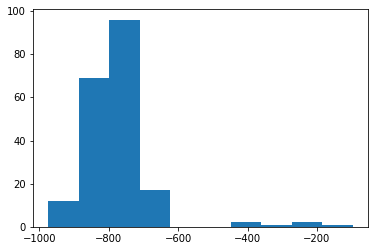

In [68]:
plt.hist(rewards_rand);

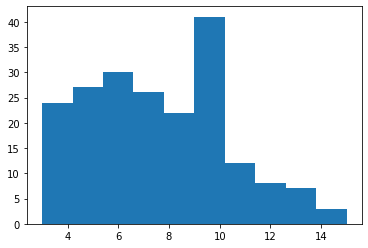

In [69]:
plt.hist(rewards_q);

We see that every iteration of the random agent yielded negative reward, which makes sense with how illegal actions lead to negative rewards at each step. For the Q-Learning algorithm, it is noteworthy that every single iteration yielded a positive score, meaning that even if some iterations took longer than others they all succeeded in dropping the passenger off eventually.

We can also investigate the average scores of the Q-Learning algorithms over different number of episodes.

In [ ]:
q1 = np.zeroes([num_states, num_actions])
train_qtable(q_table, num_episodes, alpha, gamma, epsilon)
r1 = 

In [70]:
x = []
y = []

alpha = 0.1
gamma = 0.6
epsilon = 0.1


for i in range(5, 45, 5):
    qtable = np.zeros([num_states, num_actions])
    train_qtable(qtable, i, alpha, gamma, epsilon)
    rewards_q = test_qtable(qtable, num_episodes)
    x.append(i)
    y.append(np.mean(rewards_q))

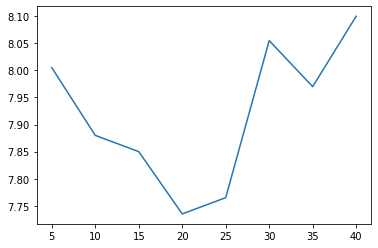

In [71]:
plt.plot(x, y)

While there isn't a particularly strong trend of increasing score with number of episodes, we can see that 40 episodes is sufficient to build up a model that yields the same accuracy as we observed with 1000 episodes earlier.

### Conclusion

This project gave me the opportunity to try and solve the taxi game through deep learning. By comparing the two models, we saw how the Q-learning algorithm produces much higher scores on average than the model that runs randomly. 

The Q-learning model worked well in this case because we had a reasonably small number of possible states, so it could be entirely captured in a table like we did here. However this would not have worked for a larger grid world, or another game with more possible states (like the Atari games). In this scenario, it would make more sense to train a function approximation of the utility estimate.

Now that I have gained some confidence in building reinforcement learning agents, my next plan is to tackle a simple Atari game in the OpenAI gym- the breakout game. This would introduce a whole host of complications, such as how to abstract the image data of the game so that it is useful for a reinforcement learning agent. With its combination of computer vision-oriented data and reinforcement learning task, the breakout game would be an ideal candidate for DQN (deep reinforcement learning), which is a topic I will have to explore further.


### References

https://www.gymlibrary.ml/environments/toy_text/taxi/

https://towardsdatascience.com/simple-reinforcement-learning-q-learning-fcddc4b6fe56

[Q-learning with numpy](https://www.youtube.com/watch?v=q2ZOEFAaaI0)

https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

